# enviLink Results

## Table of Content <a class="anchor" id="toc"></a>
#### Data
* [Globals](#globals)
* [enviLink Data Files](#eldata)
* [EAWAG-BBD and KEGG Data Frames](#datasets)

#### [Statistics](#stats)
#### [Comparison between EAWAG-BBD and KEGG](#compare)
* [Histogram](#histo)
* [Common Links](#common)
* [Exclusive Links KEGG](#keggonly)
* [Exclusive Links EAWAG-BBD](#bbdonly)

## <a class="anchor" id="globals"></a>Globals [$\Uparrow$](#toc)

In [1]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from pandas import read_csv, DataFrame, Series
import sys
sys.path.append('../src')
from ecbt import make_comparable, addEClevels, generate_heatmap, combined_histogram

## <a class="anchor" id="eldata"></a>enviLink Data Files [$\Uparrow$](#toc)
Apart from the _enviLink_ result file, four of the input files from the first step from the workflow are re-read to provide some statistical information.

In [2]:
kegg_reactions = read_csv('../data/kegg/kegg-rrole.tsv', sep="\t")
kegg_reac_enz = read_csv('../data/kegg/KEGG_reaction-enzymes.tsv', sep="\t", header=None)
eawagbbd_reactions = read_csv('../data/bbd/EAWAG-BBD_reactions.tsv', sep="\t", header=None)
eawagbbd_reac_enz = read_csv('../data/bbd/EAWAG-BBD_reaction-enzymes.tsv', sep="\t", header=None)

enviLink = read_csv('../data/enviLink.tsv', sep="\t")

## <a class="anchor" id="datasets"></a>EAWAG-BBD and KEGG Data Frame [$\Uparrow$](#toc)

In [3]:
ebbd = enviLink[enviLink.linkingMethod.str.startswith('EAWAG-BBD')]
kegg = enviLink[enviLink.linkingMethod.str.startswith('KEGG')]

## <a class="anchor" id="stats"></a>Statistics [$\Uparrow$](#toc)

In [4]:
def evidence(keggdf, bbddf, rulec, ecnc, lsuffix='kegg', rsuffix='bbd'):
    kegg_evidence = keggdf.loc[:,['evidence', rulec, ecnc]].groupby([rulec, ecnc]).count()
    bbd_evidence = bbddf.loc[:,['evidence', rulec, ecnc]].groupby([rulec, ecnc]).count()
    return kegg_evidence.join(bbd_evidence, how='outer', lsuffix=lsuffix, rsuffix=rsuffix)

def evidencecount(evidence, lsuffix='kegg', rsuffix='bbd'):
    keggies = evidence[evidence['evidence'+rsuffix].isnull()].shape[0]
    bbdies = evidence[evidence['evidence'+lsuffix].isnull()].shape[0]
    mutual = evidence[evidence['evidence'+lsuffix].notnull() & evidence['evidence'+rsuffix].notnull()].shape[0]
    
    return keggies, bbdies, mutual

### BT Rule - 3<sup>rd</sup> Level EC Class Links by Dataset
#### Venn Diagram

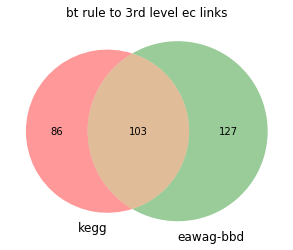

In [5]:
mixed_evidence = evidence(kegg, ebbd, rulec='rule', ecnc='3rd_lvl')

plt.title('bt rule to 3rd level ec links')
venn2(evidencecount(mixed_evidence), ['kegg', 'eawag-bbd']);

#### Percentage

In [6]:
total = sum(evidencecount(mixed_evidence))
keggonly, ebbdonly, overlap = [100*x/total for x in evidencecount(mixed_evidence)]
DataFrame(Series({
    'common links': overlap,
    'EAWAG-BBD only': ebbdonly,
    'KEGG only': keggonly}),
    columns=['percentage'])

,percentage
common links,32.594937
EAWAG-BBD only,40.189873
KEGG only,27.215190


### Number of BT Rules that are Linked to 3<sup>rd</sup> Level EC Classes

In [7]:
rules_eventually_linked = len(mixed_evidence.index.levels[0])
rules_eventually_linked

169

### Number of 3<sup>rd</sup> Level EC Classes that are Linked to a BT Rule

In [8]:
lvl3_eventually_linked = len(mixed_evidence.index.levels[1])
lvl3_eventually_linked

107

### Reaction numbers
#### KEGG

In [9]:
reaction_enzymes = kegg_reac_enz[~kegg_reac_enz[1].str.endswith('.-')]
kegg_assoc_ec_classes = reaction_enzymes[1].nunique()
kegg_reactions_considered = reaction_enzymes[0].nunique()
kegg_links_found = kegg.evidence.nunique()

DataFrame(Series({
    'total number of reactions': kegg_reactions.reaction.nunique(),
    'reactions with associated enzymes': reaction_enzymes.shape[0], 
    'included in enviLink analysis': kegg_reactions_considered, 
    'reactions that are evidence in enviLink': kegg_links_found
}), columns=['KEGG'])

,KEGG
total number of reactions,9959
reactions with associated enzymes,7007
included in enviLink analysis,6306
reactions that are evidence in enviLink,1579


#### EAWAG-BBD

In [10]:
reaction_enzymes = eawagbbd_reac_enz[~eawagbbd_reac_enz[1].str.endswith('.-.-')]
ebbd_assoc_ec_classes = reaction_enzymes[1].nunique()
ebbd_reactions_considered = reaction_enzymes[0].nunique()
ebbd_links_found = ebbd.evidence.nunique()

   
DataFrame(Series({
    'total number of reactions': eawagbbd_reactions[1].nunique(),
    'reactions with associated enzymes': reaction_enzymes.shape[0], 
    'included in enviLink analysis': ebbd_reactions_considered, 
    'reactions that are evidence in enviLink': ebbd_links_found
}), columns=['EAWAG-BBD'])

,EAWAG-BBD
total number of reactions,1479
reactions with associated enzymes,1301
included in enviLink analysis,1301
reactions that are evidence in enviLink,736


### Level Association of the EAWAG-BBD Dataset

In [11]:
counts = {
    'frst_lvl': eawagbbd_reac_enz[eawagbbd_reac_enz[2].str.endswith('.-.-.-')][0].nunique(),
    'scnd_lvl': eawagbbd_reac_enz[~eawagbbd_reac_enz[2].str.endswith('.-.-.-') & eawagbbd_reac_enz[2].str.endswith('.-.-')][0].nunique(),
    'thrd_lvl': eawagbbd_reac_enz[~eawagbbd_reac_enz[2].str.endswith('.-.-') & eawagbbd_reac_enz[2].str.endswith('.-')][0].nunique(),
    'full_lvl': eawagbbd_reac_enz[~eawagbbd_reac_enz[2].str.endswith('.-')][0].nunique()
}
DataFrame(Series(
    dict([(k, 100*v/eawagbbd_reac_enz[0].nunique()) for (k,v) in counts.items()])),
    columns=['percentage'])

,percentage
frst_lvl,0.000000
scnd_lvl,12.451960
thrd_lvl,43.428132
full_lvl,44.119908


For the KEGG dataset only enzymes with a 4<sup>th</sup> level annotation were considered.

## <a class="anchor" id="compare"></a>Link comparison between EAWAG-BBD and KEGG [$\Uparrow$](#toc)

In [12]:
ebbd.head()

,3rd_lvl,ecNumber,enzyme,evidence,evidence_link,id,linkingMethod,rule
23,1.1.2.-,1.1.2.7,methanol dehydrogenase,Eawag BBD reaction r0002,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0001
26,1.1.1.-,1.1.1.-,p-cumic alcohol dehydrogenase,Eawag BBD reaction r0393,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0001
40,1.1.3.-,1.1.3.12,pyridoxine 4-oxidase,"Eawag BBD reaction r1516, Eawag BBD reaction r...",https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0001
45,1.1.99.-,1.1.99.9,pyridoxine 5-dehydrogenase,Eawag BBD reaction r1525,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0001
58,1.1.1.-,1.1.1.183,geraniol dehydrogenase,Eawag BBD reaction r1163,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0001


In [13]:
kegg.head()

,3rd_lvl,ecNumber,enzyme,evidence,evidence_link,id,linkingMethod,rule
0,1.1.1.-,1.1.1.31,3-hydroxyisobutyrate dehydrogenase,R02047,https://www.genome.jp/dbget-bin/www_bget?rn:R0...,https://envipath.org/package/32de3cf4-e3e6-416...,KEGG 2020-10-21 enviLink,bt0001
1,1.1.1.-,1.1.1.31,3-hydroxyisobutyrate dehydrogenase,R05066,https://www.genome.jp/dbget-bin/www_bget?rn:R0...,https://envipath.org/package/32de3cf4-e3e6-416...,KEGG 2020-10-21 enviLink,bt0001
2,1.1.1.-,1.1.1.190,indole-3-acetaldehyde reductase (NADH),R02679,https://www.genome.jp/dbget-bin/www_bget?rn:R0...,https://envipath.org/package/32de3cf4-e3e6-416...,KEGG 2020-10-21 enviLink,bt0001
3,1.1.3.-,1.1.3.39,nucleoside oxidase (H2O2-forming),R05696,https://www.genome.jp/dbget-bin/www_bget?rn:R0...,https://envipath.org/package/32de3cf4-e3e6-416...,KEGG 2020-10-21 enviLink,bt0001
4,1.1.1.-,1.1.1.354,farnesol dehydrogenase (NAD+),R10412,https://www.genome.jp/dbget-bin/www_bget?rn:R1...,https://envipath.org/package/32de3cf4-e3e6-416...,KEGG 2020-10-21 enviLink,bt0001


## <a class="anchor" id="histo"></a>enviLink Histogram [$\Uparrow$](#toc)

In [14]:
ebbd_ = ebbd.copy()
addEClevels(ebbd_, coln='ecNumber')
ebbd_hm = generate_heatmap(ebbd_, level=3, rcoln='evidence', btcoln='rule')
ebbd_hm.head()

,1.1.1,1.1.2,1.1.3,1.1.7,1.1.99,1.10.3,1.11.1,1.13.11,1.13.12,1.14.11,...,5.3.2,5.3.3,5.3.99,5.4.4,5.4.99,5.5.1,5.99.1,6.2.1,6.4.1,7.2.4
bt0001,18.0,1.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bt0002,19.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bt0003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bt0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bt0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
kegg_ = kegg.copy()
addEClevels(kegg_, coln='ecNumber')
kegg_hm = generate_heatmap(kegg_, level=3, rcoln='evidence', btcoln='rule')
kegg_hm.head()

,1.1.1,1.1.3,1.1.5,1.1.98,1.1.99,1.11.1,1.11.2,1.13.11,1.14.12,1.14.13,...,4.99.1,5.3.2,5.3.3,5.3.99,5.4.4,5.4.99,5.5.1,6.2.1,6.4.1,7.3.2
bt0001,87.0,11.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bt0002,327.0,14.0,3.0,1.0,4.0,1.0,NaN,NaN,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bt0003,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bt0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bt0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
ground, overlay = make_comparable(kegg_hm, ebbd_hm)

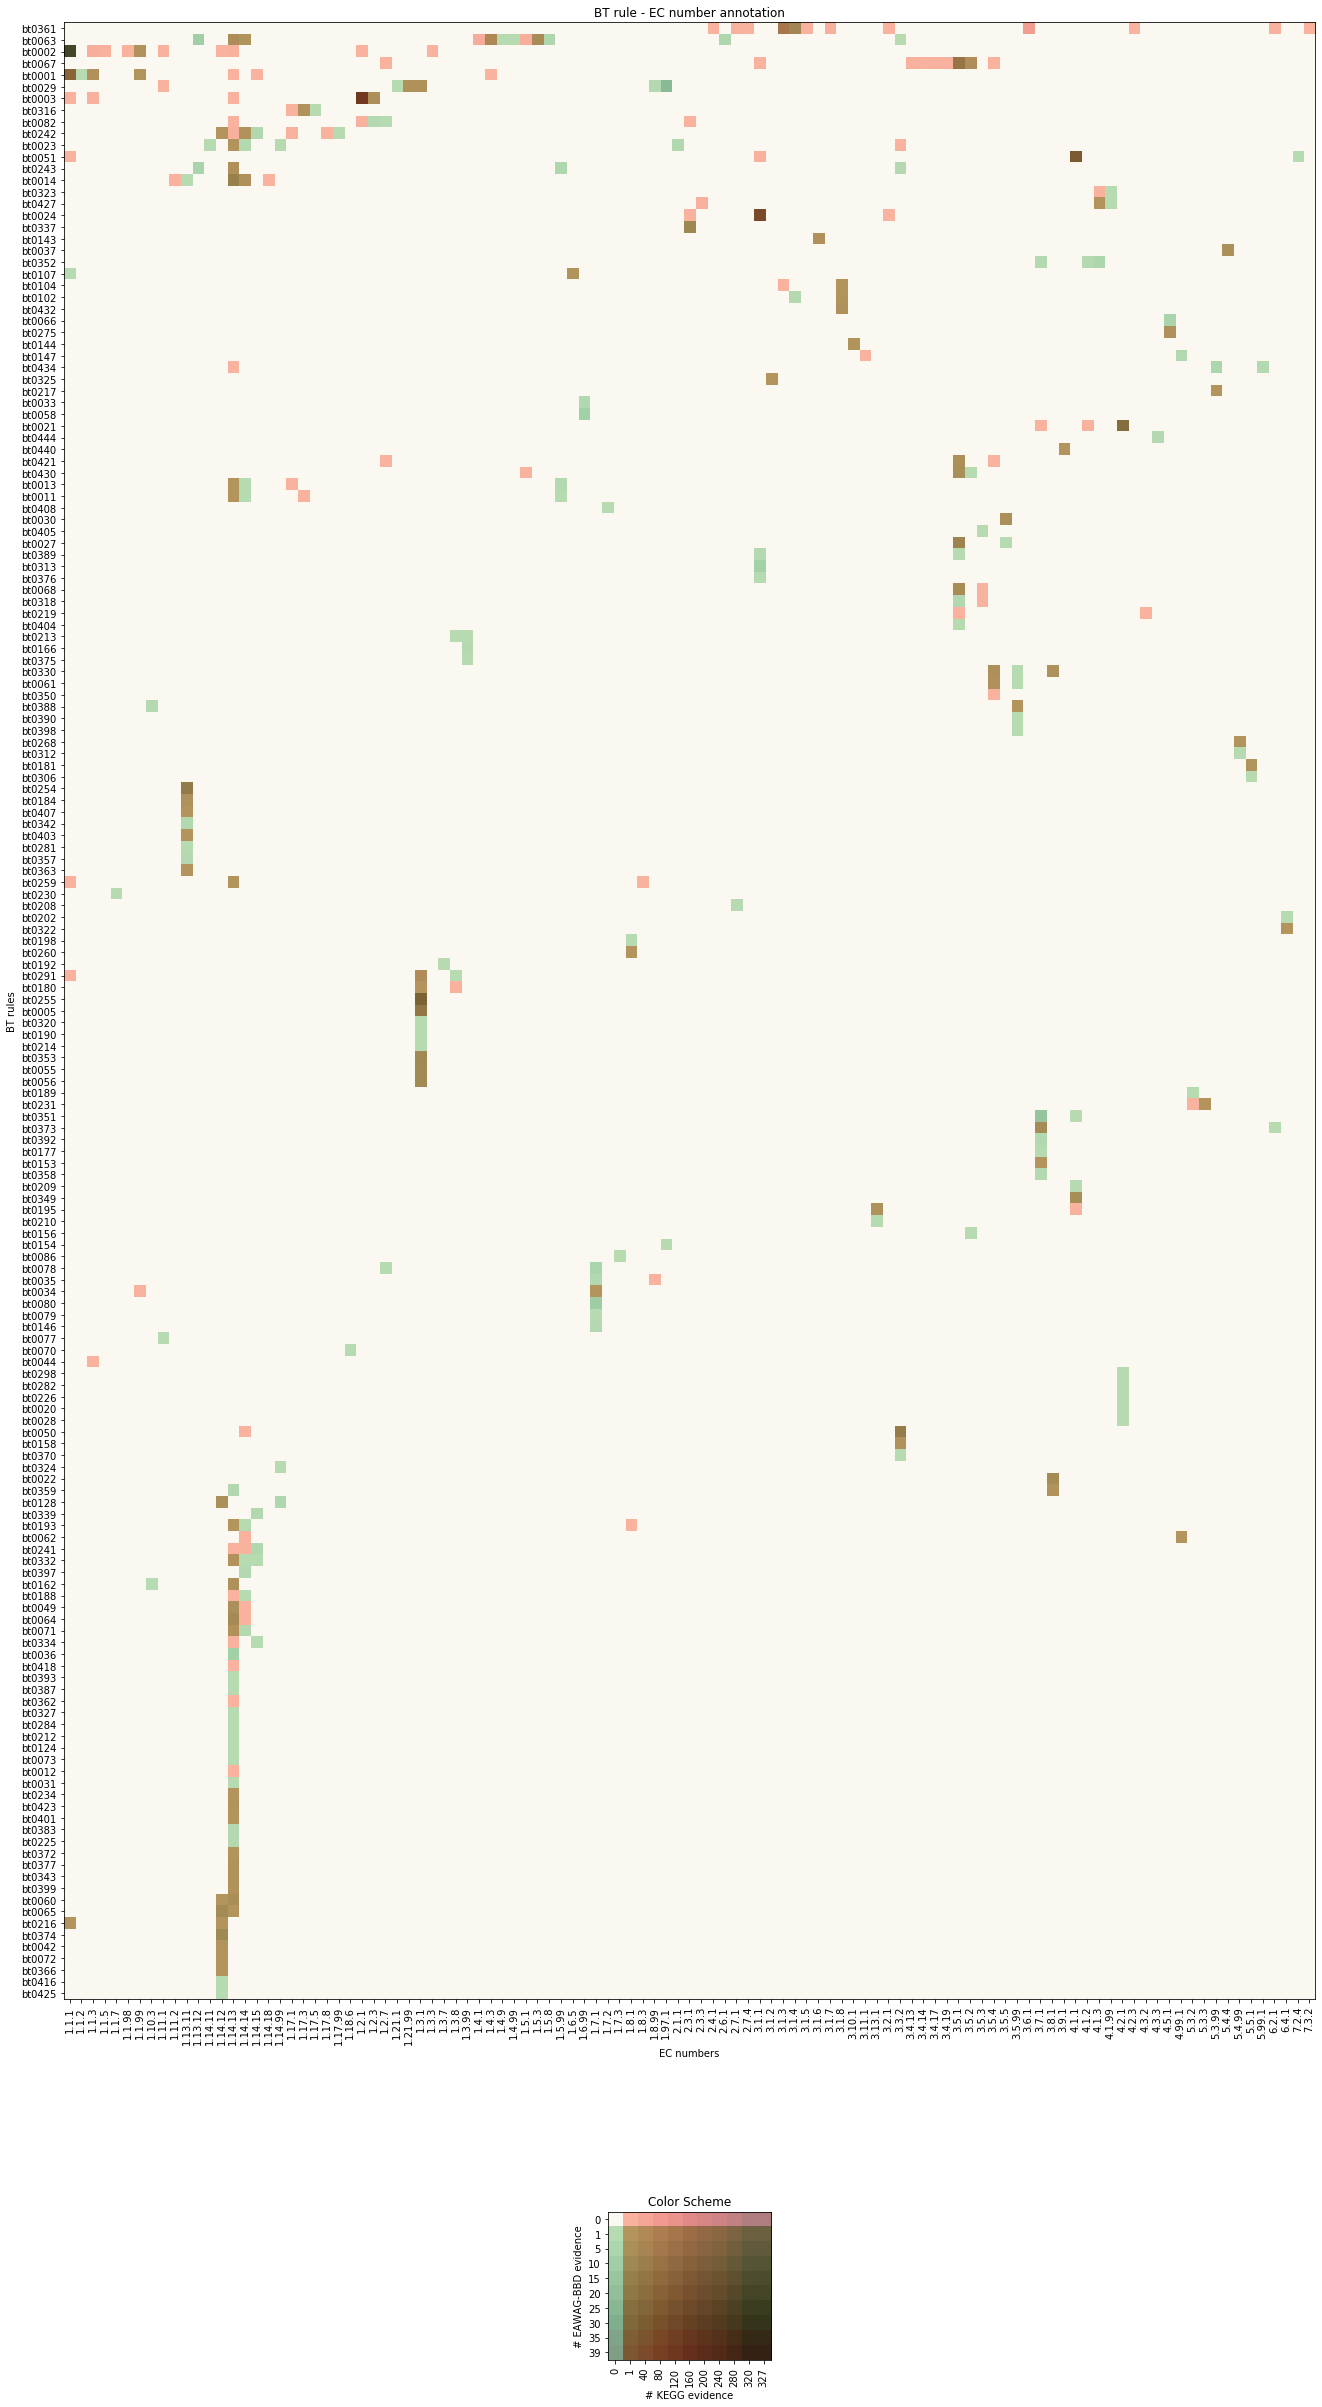

In [17]:
combined_histogram(ground, overlay, dumpfile='histogram.png')

## <a class="anchor" id="common"></a>Common assignments [$\Uparrow$](#toc)

There are 102 links that emerge from the analysis of either dataset.

In [18]:
def linkout(df, add_columns=None):
    from pandas import set_option, get_option
    max_colwidth = get_option('display.max_colwidth')
    set_option('display.max_colwidth', -1)
    df = df.copy()
    df.evidence = '<a href="' + df.evidence_link + '">' + df.evidence + '</a>'
    df['enviLink'] = '<a href="' + df.id + '">&#8618;</a>'
    try:
        from IPython.display import HTML
        columns = ['ecNumber', 'enzyme', 'evidence', 'enviLink']
        if add_columns:
            columns += add_columns
        return HTML(df.loc[:,columns].to_html(escape=False))
    finally:
        set_option('display.max_colwidth', max_colwidth)

In [19]:
common_links = mixed_evidence[mixed_evidence.evidencebbd.notnull() & mixed_evidence.evidencekegg.notnull()]
enviLink_indexed = enviLink.set_index(['rule','3rd_lvl'])
linkout(enviLink_indexed.loc[common_links.index.values, :])

## <a class="anchor" id="keggonly"></a>Additional links from KEGG analysis [$\Uparrow$](#toc)

These are the links that emerge from KEGG assignments only and were undiscovered in EAWAG-BBD:

In [20]:
kegg_only_links = mixed_evidence[mixed_evidence.evidencebbd.isnull() & mixed_evidence.evidencekegg.notnull()]
linkout(enviLink_indexed.loc[kegg_only_links.index.values, :])

In [21]:
DataFrame(Series({
    'Rule Enzyme Links that are suggested by KEGG only': kegg_only_links.shape[0], 
    'Evidence reactions': enviLink_indexed.loc[kegg_only_links.index.values, :].shape[0]
}), columns=['#'])

,#
Rule Enzyme Links that are suggested by KEGG only,86
Evidence reactions,317


In [22]:
enviLink_indexed.loc[kegg_only_links.index.values, :]\
    .groupby('rule').agg({'evidence':'nunique', 'ecNumber':'nunique'})\
    .sort_values('evidence', ascending=False).head()

,evidence,ecNumber
rule,,
bt0361,89,61
bt0063,37,34
bt0002,27,23
bt0067,20,14
bt0242,13,10


## <a class="anchor" id="bbdonly"></a>EAWAG-BBD links that are not confirmed by KEGG analysis [$\Uparrow$](#toc)

There are 123 links that emerge from EAWAG-BBD assignments only and are not supported by KEGG annotations.

In [23]:
eawagbbd_only_links = mixed_evidence[mixed_evidence.evidencebbd.notnull() & mixed_evidence.evidencekegg.isnull()]
linkout(enviLink_indexed.loc[eawagbbd_only_links.index.values, :])

In [24]:
eawagbbd_only_links.shape, enviLink_indexed.loc[eawagbbd_only_links.index.values, :].shape
DataFrame(Series({
    'Rule Enzyme Links that are suggested by EAWAG-BBD only': eawagbbd_only_links.shape[0], 
    'Evidence reactions': enviLink_indexed.loc[eawagbbd_only_links.index.values, :].shape[0]
}), columns=['#'])

,#
Rule Enzyme Links that are suggested by EAWAG-BBD only,127
Evidence reactions,285


In [25]:
enviLink_indexed.loc[eawagbbd_only_links.index.values, :]\
    .groupby('3rd_lvl').agg({'evidence':'nunique', 'ecNumber':'nunique'})\
    .sort_values('evidence', ascending=False).head()

,evidence,ecNumber
3rd_lvl,,
1.97.1.-,25,2
1.14.13.-,24,4
1.7.1.-,23,2
3.7.1.-,22,8
1.6.99.-,12,1


## Focus on a particular rule

In [26]:
enviLink[enviLink['rule'].isin(['bt0033'])]

,3rd_lvl,ecNumber,enzyme,evidence,evidence_link,id,linkingMethod,rule
1138,1.6.99.-,1.6.99.1,Type I nitroreductase,Eawag BBD reaction r0834,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0033
1139,1.6.99.-,1.6.99.1,Type I nitroreductase,Eawag BBD reaction r0835,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0033
1140,1.6.99.-,1.6.99.1,Type I nitroreductase,Eawag BBD reaction r0836,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0033


## Focus on a particular third level EC

In [27]:
enviLink[enviLink['3rd_lvl'].isin(['1.6.99.-'])]

,3rd_lvl,ecNumber,enzyme,evidence,evidence_link,id,linkingMethod,rule
1138,1.6.99.-,1.6.99.1,Type I nitroreductase,Eawag BBD reaction r0834,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0033
1139,1.6.99.-,1.6.99.1,Type I nitroreductase,Eawag BBD reaction r0835,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0033
1140,1.6.99.-,1.6.99.1,Type I nitroreductase,Eawag BBD reaction r0836,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0033
1342,1.6.99.-,1.6.99.1,xenobiotic reductase,Eawag BBD reaction r0918,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0058
1343,1.6.99.-,1.6.99.1,xenobiotic reductase,Eawag BBD reaction r0042,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0058
1344,1.6.99.-,1.6.99.1,xenobiotic reductase,Eawag BBD reaction r0043,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0058
1345,1.6.99.-,1.6.99.1,xenobiotic reductase,Eawag BBD reaction r0025,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0058
1346,1.6.99.-,1.6.99.1,xenobiotic reductase,Eawag BBD reaction r0040,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0058
1347,1.6.99.-,1.6.99.1,xenobiotic reductase,Eawag BBD reaction r0917,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0058
1348,1.6.99.-,1.6.99.1,xenobiotic reductase,Eawag BBD reaction r0039,https://envipath.org/package/32de3cf4-e3e6-416...,https://envipath.org/package/32de3cf4-e3e6-416...,EAWAG-BBD 2020-10-21 enviLink,bt0058
